# Init

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd
import os
import shutil
import cv2
import tqdm
import math

In [4]:
INPUT_DATA_DIR = "Data/"
OUTPUT_DATA_DIR = "Dataset/"
GLO_DIR = "GLO/"
DEP_DIR = "3DEP/"
DEP_NODATA = -1000000000.0
WSF_DIR = "WSF/"
OSM_DIR = "OSM/"
GLO_INTERP_DIR = "GLO_INTERP/"
GLO_REMOVED_BUILDINGS = "GLO_REMOVED_BUILDINGS/"

## Functions

In [5]:
def read_map(path):
    tmp = tiff.imread(path)
    return np.array(tmp)

In [6]:
radius = 3
kernel = np.zeros_like(np.float32, shape = [2 * radius + 1, 2 * radius + 1 ])
for i in range(2 * radius + 1):
  for j in range(2 * radius + 1):
    value = math.sqrt((i - radius) * (i - radius) + (j - radius) * (j - radius))
    if value > radius or (i == radius and j == radius):
      continue
    kernel[i, j] = 1/value

In [7]:
class ZeroKernelSum(Exception):
    pass

def interpolate(x, y, array, kernel):
  array_shape = array.shape
  kernel_shape = kernel.shape
  radius = int (kernel_shape[0] / 2 )
  kernel_copy = kernel

  for i in range(kernel_shape[0]):
    if i + x - radius < 0 or i + x - radius > array_shape[0] - 1:
      kernel_copy[i, :] = 0
      continue
    for j in range(kernel_shape[0]):
      if j + y - radius < 0 or j + y - radius > array_shape[1] - 1:
        kernel_copy[i, j] = 0
        continue
      if np.isnan(array[i + x - radius, j + y - radius]):
        kernel_copy[i, j] = 0
        continue
  #print(kernel_copy)
  if kernel_copy.sum() == 0:
    raise ZeroKernelSum("Kernel sum zero")

  kernel_copy /= kernel_copy.sum()

  result = 0
  for i in range(kernel_shape[0]):
    for j in range(kernel_shape[0]):
      if kernel_copy[i, j] == 0:
        continue
      result += kernel_copy[i,j] * array[i + x - radius, j + y - radius]

  return result

In [8]:
def interpolate_map(map):
  result = np.copy(map)
  x,y = result.shape
  while np.isnan(result).any():
    for i in range(x):
      for j in range(y):
        if not np.isnan(result[i,j]):
          continue
        try:
          result[i,j] = interpolate(i, j, result, np.copy(kernel))
        except ZeroKernelSum:
          pass
  
  return result

In [9]:
def filter_with_mask(map, mask, threashhold = 0.00001, nodata = 0):
    x,y = map.shape
    z = int(mask.shape[0] / map.shape[0])
    threshhold = threashhold*z*z

    filtered_array = np.copy(map)
    
    for i in range(x):
        for j in range(y):
            numOfBuildingPixel = 0
            for i_mask in range(z):
                for j_mask in range(z):
                    if mask[i_mask + i * z][j_mask + j * z] != nodata:
                        numOfBuildingPixel += 1
            if numOfBuildingPixel >= threshhold:
                filtered_array[i][j] = float('nan')
                    
    return filtered_array

In [10]:
CHECK_OFFSETS = [(-1,-1), (-1, 0), (-1, 1),
                 (0, -1),          (0, 1),
                 (1,-1),  (1, 0),  (1, 1)]

def get_buidlings_heights(glo, buildings, num = 10000, nodata = 0, height_quantile = 0.85):
    visited = np.where(buildings == nodata, True, False)
    buildings_heights = np.zeros(visited.shape)
    size_x, size_y = buildings.shape
    for x in range(size_x):
        for y in range(size_y):
            if not visited[x][y]:
                heights = []
                building_coordinates = []
                points_to_go = [(x,y)]
                
                while len(points_to_go) != 0:
                    i, j = points_to_go.pop()
                    visited[i][j] = True
                    heights.append(glo[int(i/9)][int(j/9)])
                    building_coordinates.append((i,j))
                    
                    for x_offset, y_offset in CHECK_OFFSETS:
                        i_offsetted = i + x_offset
                        j_offsetted = j + y_offset
                        if 0 <= i_offsetted < size_x and 0 <= j_offsetted < size_y:
                            if not visited[i_offsetted, j_offsetted]:
                                delta_height = buildings[i, j] - buildings[i_offsetted, j_offsetted]
                                if abs(delta_height) < 1:
                                    points_to_go.append((i_offsetted, j_offsetted))
                num -= 1
                if num != 0:
                   #continue
                   pass
                        
                height = np.quantile(heights, height_quantile)
                #print(height)
                #print(np.sort(heights))                
               
                for i, j in building_coordinates:
                    buildings_heights[i][j] = height
                    
                if num == 0:
                    return buildings_heights
                
                
    return buildings_heights

# Filtering initial data

In [11]:
dataset = {}

## 3DEP

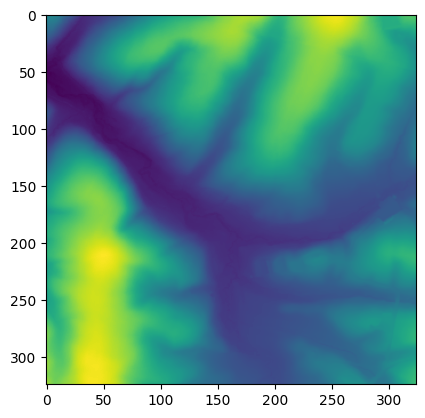

In [14]:
filelist=os.listdir(INPUT_DATA_DIR+DEP_DIR)
tmp = tiff.imread(INPUT_DATA_DIR+DEP_DIR + filelist[0])
tmp = np.array(tmp)
plt.imshow(tmp)

In [15]:
dataset["Suffix"] = []
dataset["3DEP"] = []
dataset["3DEP Max"] = []
dataset["3DEP Min"] = []
for file in tqdm.tqdm(filelist):
    tmp = read_map(INPUT_DATA_DIR+DEP_DIR + file)
    if not DEP_NODATA in tmp:
        max = tmp.max()
        min = tmp.min()
        if max != min:
            dataset["3DEP"].append(INPUT_DATA_DIR+DEP_DIR + file)
            file_parts = file.split("_")
            dataset["Suffix"].append(file_parts[-2]+ "_" + file_parts[-1])
            dataset["3DEP Max"].append(max)
            dataset["3DEP Min"].append(min)

100%|██████████| 7/7 [00:00<00:00, 304.35it/s]


In [16]:
print(len(filelist))
print(len(dataset["3DEP"]))

7
7


## GLO

In [17]:
filelist=os.listdir(INPUT_DATA_DIR+GLO_DIR)
fileprefix = INPUT_DATA_DIR+GLO_DIR + filelist[0]
fileprefix = fileprefix[:len(fileprefix) - len(dataset["Suffix"][0])]
fileprefix

'Data/GLO/GLO-30_'

In [18]:
dataset["GLO"] = []
dataset["GLO Max"]=[]
dataset["GLO Min"]=[]

for suffix in tqdm.tqdm(dataset["Suffix"]):
    tmp = read_map(fileprefix+suffix)
    dataset["GLO"].append(fileprefix+suffix)
    dataset["GLO Max"].append(tmp.max())
    dataset["GLO Min"].append(tmp.min())

len(dataset["GLO"])

100%|██████████| 7/7 [00:00<00:00, 291.62it/s]


7

## WSF

In [19]:
filelist=os.listdir(INPUT_DATA_DIR+WSF_DIR)
fileprefix = INPUT_DATA_DIR+WSF_DIR + filelist[0]
fileprefix = fileprefix[:len(fileprefix) - len(dataset["Suffix"][0])]
fileprefix

'Data/WSF/WSF2019_'

In [20]:
dataset["WSF"] = []
dataset["Has WSF"] = []
dataset["WSF Density"] = []
dataset["WSF Max"]=[]
dataset["WSF Min"]=[]

for suffix in tqdm.tqdm(dataset["Suffix"]):
    tmp = read_map(fileprefix+suffix)
    dataset["WSF"].append(fileprefix+suffix)
    dataset["Has WSF"].append(np.any(tmp))
    dataset["WSF Density"].append(np.count_nonzero(tmp) / np.size(tmp))
    dataset["WSF Max"].append(tmp.max())
    dataset["WSF Min"].append(tmp.min())

len(dataset["Has WSF"])

100%|██████████| 7/7 [00:00<00:00, 251.90it/s]


7

## OSM

In [21]:
filelist=os.listdir(INPUT_DATA_DIR+OSM_DIR)
fileprefix = INPUT_DATA_DIR+OSM_DIR + filelist[0]
fileprefix = fileprefix[:len(fileprefix) - len(dataset["Suffix"][0])]
fileprefix

'Data/OSM/Buildings_'

In [22]:
dataset["OSM"] = []
dataset["Has OSM"] = []
dataset["OSM Density"] = []
dataset["OSM Max"]=[]
dataset["OSM Min"]=[]

for suffix in tqdm.tqdm(dataset["Suffix"]):
    tmp = read_map(fileprefix+suffix)
    dataset["OSM"].append(fileprefix+suffix)
    dataset["Has OSM"].append(np.any(tmp))
    dataset["OSM Density"].append(np.count_nonzero(tmp) / np.size(tmp))
    dataset["OSM Max"].append(tmp.max())
    dataset["OSM Min"].append(tmp.min())

len(dataset["Has OSM"])

100%|██████████| 7/7 [00:00<00:00, 208.39it/s]


7

# Dataset CSV

In [23]:
df = pd.DataFrame(dataset)
df.head()

,Suffix,3DEP,3DEP Max,3DEP Min,GLO,GLO Max,GLO Min,WSF,Has WSF,WSF Density,WSF Max,WSF Min,OSM,Has OSM,OSM Density,OSM Max,OSM Min
0,001_001.tif,Data/3DEP/Clipped_Fairfox_001_001.tif,333.071869,285.800537,Data/GLO/GLO-30_001_001.tif,347.925751,291.112823,Data/WSF/WSF2019_001_001.tif,True,0.004715,255.0,0.0,Data/OSM/Buildings_001_001.tif,False,0.0,0.0,0.0
1,001_002.tif,Data/3DEP/Clipped_Fairfox_001_002.tif,382.051666,297.681946,Data/GLO/GLO-30_001_002.tif,391.852966,303.433350,Data/WSF/WSF2019_001_002.tif,True,0.010031,255.0,0.0,Data/OSM/Buildings_001_002.tif,False,0.0,0.0,0.0
2,001_003.tif,Data/3DEP/Clipped_Fairfox_001_003.tif,446.163116,306.227081,Data/GLO/GLO-30_001_003.tif,445.340149,306.260956,Data/WSF/WSF2019_001_003.tif,True,0.002315,255.0,0.0,Data/OSM/Buildings_001_003.tif,False,0.0,0.0,0.0
3,001_004.tif,Data/3DEP/Clipped_Fairfox_001_004.tif,357.027008,291.865753,Data/GLO/GLO-30_001_004.tif,362.268768,292.313995,Data/WSF/WSF2019_001_004.tif,True,0.009002,255.0,0.0,Data/OSM/Buildings_001_004.tif,False,0.0,0.0,0.0
4,001_005.tif,Data/3DEP/Clipped_Fairfox_001_005.tif,370.279327,295.192780,Data/GLO/GLO-30_001_005.tif,378.524719,294.934937,Data/WSF/WSF2019_001_005.tif,True,0.001886,255.0,0.0,Data/OSM/Buildings_001_005.tif,False,0.0,0.0,0.0


In [24]:
df.describe()

,3DEP Max,3DEP Min,GLO Max,GLO Min,WSF Density,WSF Max,WSF Min,OSM Density,OSM Max,OSM Min
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.0
mean,435.322357,310.165314,440.774170,313.853119,0.003993,182.142853,0.0,0.000015,0.142857,0.0
std,104.327560,29.877600,99.810677,32.171021,0.004107,124.427261,0.0,0.000040,0.377964,0.0
min,333.071869,285.800537,347.925751,291.112823,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,363.653168,293.529266,370.396744,293.624466,0.000943,127.500000,0.0,0.000000,0.000000,0.0
50%,382.051666,297.681946,391.852966,303.433350,0.002315,255.000000,0.0,0.000000,0.000000,0.0
75%,510.082932,314.014175,509.599060,317.096786,0.006859,255.000000,0.0,0.000000,0.000000,0.0
max,584.660828,372.588013,585.648865,380.983215,0.010031,255.000000,0.0,0.000105,1.000000,0.0


In [25]:
df.to_csv(INPUT_DATA_DIR + "FilteredData.csv")

# Copying dataset files

In [26]:
df = pd.read_csv(INPUT_DATA_DIR + "FilteredData.csv", index_col=0)
df.head()

,Suffix,3DEP,3DEP Max,3DEP Min,GLO,GLO Max,GLO Min,WSF,Has WSF,WSF Density,WSF Max,WSF Min,OSM,Has OSM,OSM Density,OSM Max,OSM Min
0,001_001.tif,Data/3DEP/Clipped_Fairfox_001_001.tif,333.07187,285.80054,Data/GLO/GLO-30_001_001.tif,347.92575,291.11282,Data/WSF/WSF2019_001_001.tif,True,0.004715,255.0,0.0,Data/OSM/Buildings_001_001.tif,False,0.0,0.0,0.0
1,001_002.tif,Data/3DEP/Clipped_Fairfox_001_002.tif,382.05167,297.68195,Data/GLO/GLO-30_001_002.tif,391.85297,303.43335,Data/WSF/WSF2019_001_002.tif,True,0.010031,255.0,0.0,Data/OSM/Buildings_001_002.tif,False,0.0,0.0,0.0
2,001_003.tif,Data/3DEP/Clipped_Fairfox_001_003.tif,446.16312,306.22708,Data/GLO/GLO-30_001_003.tif,445.34015,306.26096,Data/WSF/WSF2019_001_003.tif,True,0.002315,255.0,0.0,Data/OSM/Buildings_001_003.tif,False,0.0,0.0,0.0
3,001_004.tif,Data/3DEP/Clipped_Fairfox_001_004.tif,357.02700,291.86575,Data/GLO/GLO-30_001_004.tif,362.26877,292.31400,Data/WSF/WSF2019_001_004.tif,True,0.009002,255.0,0.0,Data/OSM/Buildings_001_004.tif,False,0.0,0.0,0.0
4,001_005.tif,Data/3DEP/Clipped_Fairfox_001_005.tif,370.27933,295.19278,Data/GLO/GLO-30_001_005.tif,378.52472,294.93494,Data/WSF/WSF2019_001_005.tif,True,0.001886,255.0,0.0,Data/OSM/Buildings_001_005.tif,False,0.0,0.0,0.0


In [27]:
dirs_to_make = [OUTPUT_DATA_DIR,
                OUTPUT_DATA_DIR + DEP_DIR,
                OUTPUT_DATA_DIR + OSM_DIR,
                OUTPUT_DATA_DIR + WSF_DIR,
                OUTPUT_DATA_DIR + GLO_DIR]

for dir in dirs_to_make:
    if not os.path.isdir(dir):
        os.mkdir(dir)    

In [28]:
for index, row in tqdm.tqdm(df.iterrows()):
    shutil.copyfile(row["3DEP"], OUTPUT_DATA_DIR+DEP_DIR+row["Suffix"])
    shutil.copyfile(row["OSM"], OUTPUT_DATA_DIR+OSM_DIR+row["Suffix"])
    shutil.copyfile(row["WSF"], OUTPUT_DATA_DIR+WSF_DIR+row["Suffix"])
    shutil.copyfile(row["GLO"], OUTPUT_DATA_DIR+GLO_DIR+row["Suffix"])

7it [00:00, 499.95it/s]


In [29]:
dataset_df = df.drop(labels = ["3DEP", "OSM", "WSF", "GLO"], axis = 1)
dataset_df.head()

,Suffix,3DEP Max,3DEP Min,GLO Max,GLO Min,Has WSF,WSF Density,WSF Max,WSF Min,Has OSM,OSM Density,OSM Max,OSM Min
0,001_001.tif,333.07187,285.80054,347.92575,291.11282,True,0.004715,255.0,0.0,False,0.0,0.0,0.0
1,001_002.tif,382.05167,297.68195,391.85297,303.43335,True,0.010031,255.0,0.0,False,0.0,0.0,0.0
2,001_003.tif,446.16312,306.22708,445.34015,306.26096,True,0.002315,255.0,0.0,False,0.0,0.0,0.0
3,001_004.tif,357.02700,291.86575,362.26877,292.31400,True,0.009002,255.0,0.0,False,0.0,0.0,0.0
4,001_005.tif,370.27933,295.19278,378.52472,294.93494,True,0.001886,255.0,0.0,False,0.0,0.0,0.0


In [30]:
dataset_df.to_csv(OUTPUT_DATA_DIR + "Data.csv")

# Zipping

In [ ]:
shutil.make_archive("Dataset", "zip", OUTPUT_DATA_DIR)

# Preprocessing
Not necessary for result recreation

## GLO Interpolation

In [31]:
dirs_to_make = [OUTPUT_DATA_DIR + GLO_INTERP_DIR]

for dir in dirs_to_make:
    if not os.path.isdir(dir):
        os.mkdir(dir)    

In [32]:
df = pd.read_csv(OUTPUT_DATA_DIR + "/Data.csv", index_col=0)
df.head()

,Suffix,3DEP Max,3DEP Min,GLO Max,GLO Min,Has WSF,WSF Density,WSF Max,WSF Min,Has OSM,OSM Density,OSM Max,OSM Min
0,001_001.tif,333.07187,285.80054,347.92575,291.11282,True,0.004715,255.0,0.0,False,0.0,0.0,0.0
1,001_002.tif,382.05167,297.68195,391.85297,303.43335,True,0.010031,255.0,0.0,False,0.0,0.0,0.0
2,001_003.tif,446.16312,306.22708,445.34015,306.26096,True,0.002315,255.0,0.0,False,0.0,0.0,0.0
3,001_004.tif,357.02700,291.86575,362.26877,292.31400,True,0.009002,255.0,0.0,False,0.0,0.0,0.0
4,001_005.tif,370.27933,295.19278,378.52472,294.93494,True,0.001886,255.0,0.0,False,0.0,0.0,0.0


In [33]:
for index, row in tqdm.tqdm(df.iterrows()):
    tmp = tiff.imread(OUTPUT_DATA_DIR + GLO_DIR + row["Suffix"])
    tmp = np.array(tmp)
    tmp = cv2.resize(tmp, dsize=np.multiply(tmp.shape, 3), interpolation=cv2.INTER_CUBIC)
    tiff.imwrite(OUTPUT_DATA_DIR + GLO_INTERP_DIR + row["Suffix"], tmp)

7it [00:00, 380.88it/s]


## Removing Buildings

In [34]:
df_buildings = df.drop(df[df["Has OSM"] == False].index)
print(df_buildings.describe())

       3DEP Max  3DEP Min    GLO Max    GLO Min  WSF Density  WSF Max  \
count    1.0000     1.000    1.00000    1.00000          1.0      1.0   
mean   584.6608   372.588  585.64886  380.98322          0.0      0.0   
std         NaN       NaN        NaN        NaN          NaN      NaN   
min    584.6608   372.588  585.64886  380.98322          0.0      0.0   
25%    584.6608   372.588  585.64886  380.98322          0.0      0.0   
50%    584.6608   372.588  585.64886  380.98322          0.0      0.0   
75%    584.6608   372.588  585.64886  380.98322          0.0      0.0   
max    584.6608   372.588  585.64886  380.98322          0.0      0.0   

       WSF Min  OSM Density  OSM Max  OSM Min  
count      1.0     1.000000      1.0      1.0  
mean       0.0     0.000105      1.0      0.0  
std        NaN          NaN      NaN      NaN  
min        0.0     0.000105      1.0      0.0  
25%        0.0     0.000105      1.0      0.0  
50%        0.0     0.000105      1.0      0.0  
75%   

Dataset/OSM/001_007.tif


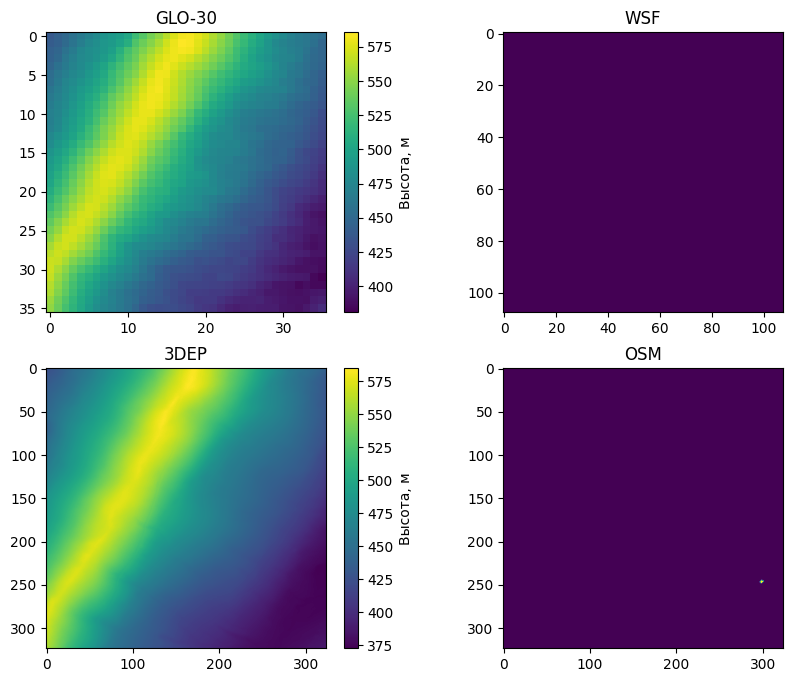

In [36]:
suffix =  df_buildings["Suffix"].values[30]
path = OUTPUT_DATA_DIR + OSM_DIR + suffix
osm= read_map(path)
print(path)
path = OUTPUT_DATA_DIR + GLO_DIR + suffix
glo = read_map(path)
path = OUTPUT_DATA_DIR + WSF_DIR + suffix
wsf = read_map(path)
path = OUTPUT_DATA_DIR + DEP_DIR + suffix
dep = read_map(path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
plt.subplot(2, 2, 2)
plt.imshow(wsf)
plt.title("WSF")
plt.subplot(2, 2, 4)
plt.imshow(osm)
plt.title("OSM")
ax = plt.subplot(2, 2, 3)
plt.imshow(dep)
plt.title("3DEP")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

In [37]:
glo_filt_wsf = filter_with_mask(glo, wsf)
glo_filt_osm = filter_with_mask(glo, osm)

In [38]:
glo_interp_wsf = interpolate_map(glo_filt_wsf)
glo_interp_osm = interpolate_map(glo_filt_osm)

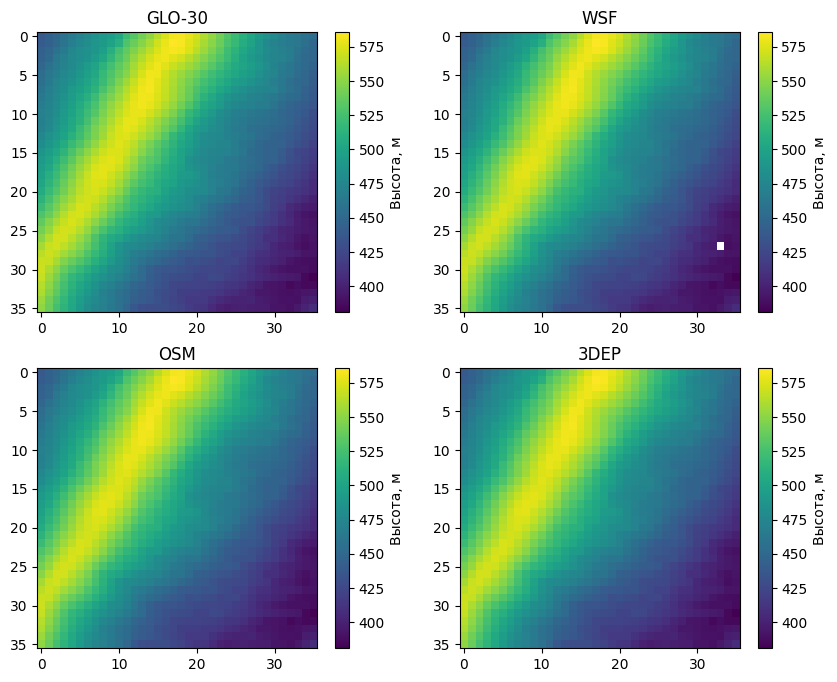

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo_filt_wsf)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
ax = plt.subplot(2, 2, 2)
plt.imshow(glo_filt_osm)
plt.title("WSF")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 3)
plt.imshow(glo_interp_wsf)
plt.title("OSM")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 4)
plt.imshow(glo_interp_osm)
plt.title("3DEP")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

In [40]:
WSF_weight = 1
OSM_weight = 1
mean = (glo_interp_osm * OSM_weight + glo_interp_wsf * WSF_weight) / (WSF_weight + OSM_weight)

#### Testing

In [41]:
tmp = tiff.imread(OUTPUT_DATA_DIR + GLO_DIR + suffix)
glo = np.array(tmp)
glo_orig_filt_osm = filter_with_mask(glo, wsf)
glo_orig_interp_osm = interpolate_map(glo_orig_filt_osm)
glo_orig_no_buildings = cv2.resize(glo_orig_interp_osm, dsize=np.multiply(tmp.shape, 3), interpolation=cv2.INTER_CUBIC)

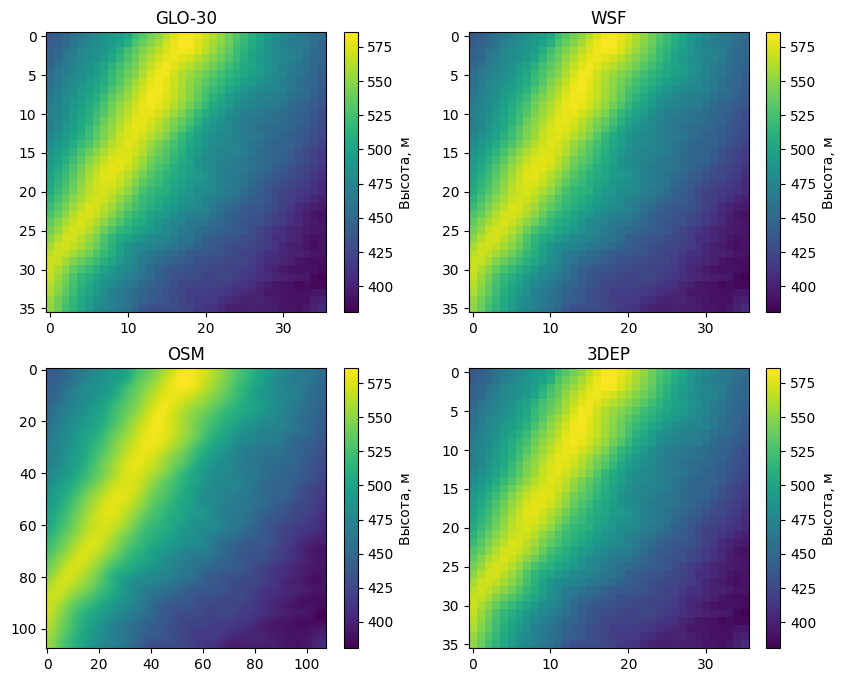

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo_orig_filt_osm)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
ax = plt.subplot(2, 2, 2)
plt.imshow(glo_filt_wsf)
plt.title("WSF")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 3)
plt.imshow(glo_orig_no_buildings)
plt.title("OSM")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 4)
plt.imshow(glo_interp_wsf)
plt.title("3DEP")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

### Save

In [43]:
WSF_weight = 1
OSM_weight = 1

dirs_to_make = [OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS,
                OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS + OSM_DIR,
                OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS + WSF_DIR]

for dir in dirs_to_make:
    if not os.path.isdir(dir):
        os.mkdir(dir)    
        
for index, row in tqdm.tqdm(df_buildings.iterrows()):
    suffix = row["Suffix"]
    osm= read_map(OUTPUT_DATA_DIR + OSM_DIR + suffix)
    glo = read_map(OUTPUT_DATA_DIR + GLO_DIR + suffix)
    wsf = read_map(OUTPUT_DATA_DIR + WSF_DIR + suffix)
    
    glo_filt_wsf = filter_with_mask(glo, wsf)
    glo_filt_osm = filter_with_mask(glo, osm)
    
    glo_interp_wsf = interpolate_map(glo_filt_wsf)
    glo_interp_osm = interpolate_map(glo_filt_osm)
    
    glo_scaled_wsf = cv2.resize(glo_interp_wsf, dsize=np.multiply(glo_interp_wsf.shape, 3), interpolation=cv2.INTER_CUBIC)
    glo_scaled_osm = cv2.resize(glo_interp_osm, dsize=np.multiply(glo_interp_osm.shape, 3), interpolation=cv2.INTER_CUBIC)
    
    tiff.imwrite(OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS + OSM_DIR + row["Suffix"], glo_scaled_osm)
    tiff.imwrite(OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS + WSF_DIR + row["Suffix"], glo_scaled_wsf)
    mean = (glo_scaled_osm * OSM_weight + glo_scaled_wsf * WSF_weight) / (WSF_weight + OSM_weight)
    tiff.imwrite(OUTPUT_DATA_DIR + GLO_REMOVED_BUILDINGS + row["Suffix"], mean)

1it [00:00,  5.65it/s]


## Test on errors in dataset

In [44]:
df = pd.read_csv(OUTPUT_DATA_DIR + "/Data.csv", index_col=0)
for index, row in tqdm.tqdm(df.iterrows()):
    suffix = row["Suffix"]
    dep= read_map(OUTPUT_DATA_DIR + DEP_DIR + suffix)
    if np.isnan(dep).any():
        print("ERROR", suffix)

7it [00:00, 1750.44it/s]
